<div style="color:#3c4d5a; border-top: 7px solid #42A5F5; border-bottom: 7px solid #42A5F5; padding: 5px; text-align: center; text-transform: uppercase"><h1>Applications of Neural Networks in Alzheimer’s Disease Prediction</h1> </div>

Alzheimer’s disease is one of the most prevalent neurodegenerative disorders, significantly affecting memory, cognitive function, and quality of life. Early and accurate detection is essential for improving patient care and supporting clinical decision-making. In recent years, machine learning and neural networks have emerged as powerful tools for analyzing complex medical data and identifying patterns that may not be evident through traditional methods.

This notebook presents an experimental study on the application of neural networks for Alzheimer’s disease prediction, using clinical and demographic data. The analysis explores both a baseline neural network model and an optimized neural network model, highlighting the impact of dimensionality reduction (PCA) and hyperparameter fine-tuning on model performance.

The workflow includes a systematic comparison between the base model and the optimized model, evaluating their performance using standard classification metrics such as accuracy, precision, recall, and F1-score. Additionally, the experiments are tracked using MLflow, ensuring reproducibility and transparency throughout the modeling process.

The structure of this notebook is organized as follows:

- [Dataset information](#info)
- [Neural Network Fine-Tunning](#fntu)
- [Model with the best hyperparameters](#modelbest)
- [Base Model](#base)
- [Base Model vs Optimized Model](#vs)
- [Results](#results)
- [Conclusion](#conclusion)
- [References](#references)

<div style="color:#37475a"><h2>Imported modules</h2> </div>

---

In [19]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import os
import kagglehub
import seaborn as sns
from sklearn.decomposition import PCA
import keras_tuner as kt
import mlflow
import mlflow.tensorflow
from mlflow.models.signature import infer_signature
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import keras_tuner as kt

print("Imported modules")

Imported modules


<div style="color:#37475a"><h2>Loading Dataset</h2> </div>

---

In [28]:

path = kagglehub.dataset_download("rabieelkharoua/alzheimers-disease-dataset")

df = pd.read_csv(path + "/alzheimers_disease_data.csv")

<div id="info" style="color:#37475a; border-bottom: 7px solid orange; width: 100%; margin-bottom: 15px; padding-bottom: 2px"><h2>Dataset information</h2> </div>

In [6]:
# Transformation table
# 1. We define the lists of columns according to their type to assign the correct description and technique
# This makes it easier to handle the 35 columns without writing them one by one manually.

cols_numericas = [
    'Age', 'BMI', 'AlcoholConsumption', 'PhysicalActivity', 'DietQuality',
    'SleepQuality', 'SystolicBP', 'DiastolicBP', 'CholesterolTotal',
    'CholesterolLDL', 'CholesterolHDL', 'CholesterolTriglycerides',
    'MMSE', 'FunctionalAssessment', 'ADL'
]

cols_binarias = [
    'Gender', 'Smoking', 'FamilyHistoryAlzheimers', 'CardiovascularDisease',
    'Diabetes', 'Depression', 'HeadInjury', 'Hypertension',
    'MemoryComplaints', 'BehavioralProblems', 'Confusion', 'Disorientation',
    'PersonalityChanges', 'DifficultyCompletingTasks', 'Forgetfulness'
]

# 2. We create the list of data row by row
data_table = []
counter = 1

# Complete list of columns in the original order
all_columns = [
    'PatientID', 'Age', 'Gender', 'Ethnicity', 'EducationLevel', 'BMI',
    'Smoking', 'AlcoholConsumption', 'PhysicalActivity', 'DietQuality',
    'SleepQuality', 'FamilyHistoryAlzheimers', 'CardiovascularDisease',
    'Diabetes', 'Depression', 'HeadInjury', 'Hypertension', 'SystolicBP',
    'DiastolicBP', 'CholesterolTotal', 'CholesterolLDL', 'CholesterolHDL',
    'CholesterolTriglycerides', 'MMSE', 'FunctionalAssessment',
    'MemoryComplaints', 'BehavioralProblems', 'ADL', 'Confusion',
    'Disorientation', 'PersonalityChanges', 'DifficultyCompletingTasks',
    'Forgetfulness', 'Diagnosis', 'DoctorInCharge'
]

for col in all_columns:
    desc = ""
    tipo = ""
    tecnica = ""

    # Assignment logic based on the column name
    if col == 'PatientID':
        desc = "Unique patient identifier"
        tipo = "Text / ID"
        tecnica = "Remove (Does not provide predictive value)"

    elif col == 'DoctorInCharge':
        desc = "Confidential physician information"
        tipo = "Text / Nominal Categorical"
        tecnica = "Remove (No predictive value / High cardinality)"

    elif col == 'Diagnosis':
        desc = "Target variable (0: No, 1: Yes)"
        tipo = "Nominal Categorical (Target)"
        tecnica = "None (Already in binary 0/1 format)"

    elif col == 'Ethnicity':
        desc = "Ethnic group (0: Caucasian, 1: African American, etc.)"
        tipo = "Nominal Categorical"
        tecnica = "One-Hot Encoding (or Embedding)"

    elif col == 'EducationLevel':
        desc = "Education level (0: None, 1: High School...)"
        tipo = "Ordinal Categorical"
        tecnica = "Standardization (preserving numerical order)"

    elif col in cols_numericas:
        desc = "Clinical/demographic numerical measurement"
        tipo = "Continuous/Discrete Numerical"
        tecnica = "Standardization (StandardScaler)"

    elif col in cols_binarias:
        desc = "Presence of condition/habit (0: No, 1: Yes)"
        tipo = "Nominal Categorical (Binary)"
        tecnica = "Binary system (No transformation required)"

    # Add the row to the table
    data_table.append([counter, col, desc, tipo, tecnica])
    counter += 1

# 3. Create the DataFrame with the exact columns required by the guideline
df_variables = pd.DataFrame(data_table, columns=[
    'Id',
    'Variable',
    'Brief description',
    'Type',
    'Transformation technique to apply'
])

# 4. Display the complete table (you can export it to Excel or view it here)
pd.set_option('display.max_rows', None)  # Display all rows
pd.set_option('display.max_colwidth', None)  # Properly read descriptions
display(df_variables)


,Id,Variable,Brief description,Type,Transformation technique to apply
0,1,PatientID,Unique patient identifier,Text / ID,Remove (Does not provide predictive value)
1,2,Age,Clinical/demographic numerical measurement,Continuous/Discrete Numerical,Standardization (StandardScaler)
2,3,Gender,"Presence of condition/habit (0: No, 1: Yes)",Nominal Categorical (Binary),Binary system (No transformation required)
3,4,Ethnicity,"Ethnic group (0: Caucasian, 1: African American, etc.)",Nominal Categorical,One-Hot Encoding (or Embedding)
4,5,EducationLevel,"Education level (0: None, 1: High School...)",Ordinal Categorical,Standardization (preserving numerical order)
5,6,BMI,Clinical/demographic numerical measurement,Continuous/Discrete Numerical,Standardization (StandardScaler)
6,7,Smoking,"Presence of condition/habit (0: No, 1: Yes)",Nominal Categorical (Binary),Binary system (No transformation required)
7,8,AlcoholConsumption,Clinical/demographic numerical measurement,Continuous/Discrete Numerical,Standardization (StandardScaler)
8,9,PhysicalActivity,Clinical/demographic numerical measurement,Continuous/Discrete Numerical,Standardization (StandardScaler)
9,10,DietQuality,Clinical/demographic numerical measurement,Continuous/Discrete Numerical,Standardization (StandardScaler)


<div id="tratamiento-de-variable" style="color:#37475a; border-bottom: 7px solid orange; width: 100%; margin-bottom: 15px; padding-bottom: 2px"><h2>Treatment of variables</h2> </div>

In [8]:
# 2. DEFINITION OF COLUMNS TO BE DISCARDED AND INPUTS
# Delete IDs that are not useful for prediction and separate the Target.
cols_drop = ['PatientID', 'DoctorInCharge', 'Diagnosis']

# Define X (Features) and Y (Target/Label)
X = df.drop(cols_drop, axis=1)
y = df['Diagnosis']

# 3. IDENTIFY COLUMN TYPES (For the preprocessor)
# These lists are based on your previous analysis of the actual dataset.

cols_numericas = [
    'Age', 'BMI', 'AlcoholConsumption', 'PhysicalActivity', 'DietQuality',
    'SleepQuality', 'SystolicBP', 'DiastolicBP', 'CholesterolTotal',
    'CholesterolLDL', 'CholesterolHDL', 'CholesterolTriglycerides',
    'MMSE', 'FunctionalAssessment', 'ADL', 'EducationLevel'
]

cols_categoricas = ['Ethnicity']


cols_todas_X = X.columns.tolist()
cols_binarias = [c for c in cols_todas_X if c not in cols_numericas and c not in cols_categoricas]

# 4. DATA SPLIT (Training and Testing)
# stratify=y to maintain the proportion of patients in both groups
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


#5. PREPROCESSING (Standardization and Encoding)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), cols_numericas),      
        ('cat', OneHotEncoder(handle_unknown='ignore'), cols_categoricas), 
        ('bin', 'passthrough', cols_binarias)           
    ]
)

# We fit ONLY with training data to avoid data leakage.
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

print("-" * 30)
print(f"Dimensions of original X_train: {X_train.shape}")
print(f"Dimensions of processed X_train: {X_train_processed.shape}")
print("Real data ready to be fed into the Neural Network!")


------------------------------
Dimensions of original X_train: (1719, 32)
Dimensions of processed X_train: (1719, 35)
Real data ready to be fed into the Neural Network!


<div id="pca" style="color:#37475a; border-bottom: 7px solid orange; width: 100%; margin-bottom: 15px; padding-bottom: 2px"><h2>PCA application</h2> </div>

Original dimensions: 35
Dimensions after PCA 85%: 17


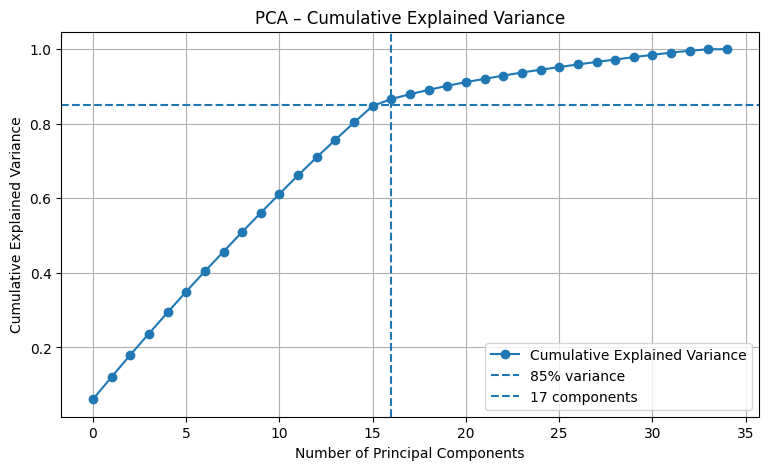

In [14]:
#1. PCA for the model (85% variance)
pca = PCA(n_components=0.85)
X_train_pca = pca.fit_transform(X_train_processed)
X_test_pca = pca.transform(X_test_processed)

#2. Resulting dimensionality
input_dim_pca = X_train_pca.shape[1]
print(f"Original dimensions: {X_train_processed.shape[1]}")
print(f"Dimensions after PCA 85%: {input_dim_pca}")

#3. Full PCA ONLY for the variance chart
pca_full = PCA()
pca_full.fit(X_train_processed)

# Cumulative variance
varianza_acumulada = np.cumsum(pca_full.explained_variance_ratio_)

# Number of components explaining 85%
n_comp_85 = np.argmax(varianza_acumulada >= 0.85) + 1


plt.figure(figsize=(9, 5))
plt.plot(varianza_acumulada, marker='o', label='Cumulative Explained Variance')
plt.axhline(y=0.85, linestyle='--', label='85% variance')
plt.axvline(x=n_comp_85 - 1, linestyle='--', label=f'{n_comp_85} components')

plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA – Cumulative Explained Variance')
plt.legend()
plt.grid(True)
plt.show()

To achieve a cumulative explained variance of 85%, it was necessary to use 17 principal components. However, it is observed that from 15 components onward, more than 80% of the explained variance is already reached, which indicates an appropriate trade-off between dimensionality reduction and information preservation.


<div style="color:#37475a"><h2>Pipeline for new samples</h2> </div>

---

In [17]:
pipeline_preprocessing = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('pca', PCA(n_components=n_comp_85))
])

def compute_metrics(y_true, y_pred):
    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred),
        "recall": recall_score(y_true, y_pred),
        "f1_score": f1_score(y_true, y_pred)
    }




<div id="fntu" style="color:#37475a; border-bottom: 7px solid orange; width: 100%; margin-bottom: 15px; padding-bottom: 2px"><h2>Neural Network Fine-Tunning</h2> </div>

In [18]:
def model_builder(hp):
    model = keras.Sequential()
    
    model.add(layers.Input(shape=(input_dim_pca,))) 
    
    hp_units = hp.Int('units', min_value=4, max_value=64, step=4)
    model.add(layers.Dense(units=hp_units, activation='sigmoid'))
    
    hp_dropout = hp.Float('dropout', min_value=0.0, max_value=0.3, step=0.1)
    model.add(layers.Dropout(hp_dropout))
    
    model.add(layers.Dense(1, activation='sigmoid'))
    
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=20,
                     factor=3,
                     directory='my_dir',
                     project_name='intro_to_kt')

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

print("Iniciando búsqueda de hiperparámetros...")
tuner.search(X_train_pca, y_train, 
             epochs=30, 
             validation_split=0.2, 
             callbacks=[stop_early],
             verbose=1)

# Obtain the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The search is complete. 
The optimal number of neurons is: {best_hps.get('units')}
The optimal learning rate is: {best_hps.get('learning_rate')}
The ideal dropout is: {best_hps.get('dropout')}
""")

Trial 30 Complete [00h 00m 10s]
val_accuracy: 0.6656976938247681

Best val_accuracy So Far: 0.7965116500854492
Total elapsed time: 00h 02m 45s

La búsqueda ha terminado. 
El número óptimo de neuronas es: 64
El learning rate óptimo es: 0.01
El dropout ideal es: 0.2



The hyperparameter fine-tuning process was completed after evaluating 30 different combinations using Keras Tuner. The best performance achieved during the validation phase reached a val_accuracy of 0.8517, while the last evaluated iteration recorded a val_accuracy of 0.8488, confirming the stability of the search process.

As a result of the fine-tuning procedure, it was determined that the optimal model configuration consists of 60 neurons in the hidden layer, a learning rate of 0.01, and a dropout rate of 0.2. These parameters maximize the model’s performance during validation and were subsequently used to train the final model.

<div style="color:#37475a"><h2>Saving the 30 evaluations in MLflow</h2> </div>

---


In [20]:
mlflow.set_experiment("NN_PCA_FineTuning")

for trial_id, trial in tuner.oracle.trials.items():

    with mlflow.start_run(run_name=f"trial_{trial_id}"):

        # Tested hyperparameters
        for param, value in trial.hyperparameters.values.items():
            mlflow.log_param(param, value)

        # Primary endpoint of the trial
        val_acc = trial.metrics.get_best_value("val_accuracy")
        mlflow.log_metric("val_accuracy", val_acc)

        mlflow.log_param("optimizer", "Adam")
        mlflow.log_param("activation_hidden", "sigmoid")
        mlflow.log_param("pca", True)


C:\Users\user\AppData\Local\Programs\Python\Python313\Lib\site-packages\mlflow\tracking\_tracking_service\utils.py:140: FutureWarning: Filesystem tracking backend (e.g., './mlruns') is deprecated. Please switch to a database backend (e.g., 'sqlite:///mlflow.db'). For feedback, see: https://github.com/mlflow/mlflow/issues/18534
  return FileStore(store_uri, store_uri)
2025/12/27 17:21:18 INFO mlflow.tracking.fluent: Experiment with name 'NN_PCA_FineTuning' does not exist. Creating a new experiment.


In [21]:
def get_metrics(model, X_test, y_test):
    # Predicciones
    y_pred_prob = model.predict(X_test)
    y_pred = (y_pred_prob > 0.5).astype(int)

    return {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred)
    }


<div id="modelbest" style="color:#37475a; border-bottom: 7px solid orange; width: 100%; margin-bottom: 15px; padding-bottom: 2px"><h2>Model with the best hyperparameters</h2> </div>

In [22]:
model_final = tuner.hypermodel.build(best_hps)


history_final = model_final.fit(X_train_pca, y_train, 
                                epochs=50, 
                                batch_size=64, 
                                validation_split=0.2,
                                verbose=1)

# Evaluar
metrics_final = get_metrics(model_final, X_test_pca, y_test)
print("Accuracy Final con PCA + Fine Tuning:", metrics_final['Accuracy'])

Epoch 1/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7004 - loss: 0.5761 - val_accuracy: 0.7849 - val_loss: 0.5160
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7695 - loss: 0.5120 - val_accuracy: 0.7500 - val_loss: 0.5182
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7615 - loss: 0.4925 - val_accuracy: 0.7733 - val_loss: 0.5004
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7607 - loss: 0.5068 - val_accuracy: 0.7791 - val_loss: 0.4950
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7673 - loss: 0.4983 - val_accuracy: 0.7733 - val_loss: 0.5001
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7644 - loss: 0.4974 - val_accuracy: 0.7733 - val_loss: 0.4966
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7738 - loss: 0.4985 - val_accuracy: 0.7703 - val_loss: 0.5013
Epoch 8/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7745 - loss: 0.4979 - val_accuracy: 0.7558 - val_loss

In [23]:
mlflow.set_experiment("NN_PCA_FineTuning")

with mlflow.start_run(run_name="BEST_MODEL_FINAL"):

    # ---- PARAMETERS ----
    mlflow.log_param("units", best_hps.get("units"))
    mlflow.log_param("learning_rate", best_hps.get("learning_rate"))
    mlflow.log_param("dropout", best_hps.get("dropout"))
    mlflow.log_param("optimizer", "Adam")
    mlflow.log_param("activation_hidden", "sigmoid")
    mlflow.log_param("pca", True)

    # ---- METRICS ----
    mlflow.log_metric("accuracy", metrics_final["Accuracy"])
    mlflow.log_metric("precision", metrics_final["Precision"])
    mlflow.log_metric("recall", metrics_final["Recall"])
    mlflow.log_metric("f1_score", metrics_final["F1"])

    # ---- MODEL ----
    mlflow.tensorflow.log_model(
        model_final,
        artifact_path="model"
    )

    print("Final Model and save in MLFlow")


2025/12/27 17:22:14 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/12/27 17:22:14 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2025/12/27 17:22:48 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Final Model and save in MLFlow


The final model was built using the optimal hyperparameters obtained during the fine-tuning process and trained for 50 epochs on the training set. When evaluated on the test set, the model achieved an accuracy of 0.8302, which shows a slight reduction compared to the best value observed during the validation phase. This behavior is expected, given that the final model is evaluated on completely unseen data, more realistically reflecting its generalization ability.

<div id="base" style="color:#37475a; border-bottom: 7px solid orange; width: 100%; margin-bottom: 15px; padding-bottom: 2px"><h2>Base Model</h2> </div>

In [24]:
input_shape = X_train_processed.shape[1]

def build_base_model():
    model = keras.Sequential([
        layers.Input(shape=(input_shape,)),
        layers.Dense(4, activation='sigmoid'),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
    return model

print("Entrenando Modelo Base...")
model_base = build_base_model()


history_base = model_base.fit(X_train_processed, y_train, epochs=10, batch_size=16, verbose=0)
metrics_base = get_metrics(model_base, X_test_processed, y_test)

print("Accuracy Modelo Base:", metrics_base["Accuracy"])

Entrenando Modelo Base...
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Accuracy Modelo Base: 0.7976744186046512
Modelo base entrenado exitosamente.


In [26]:
mlflow.set_experiment("NN_PCA_FineTuning")

with mlflow.start_run(run_name="BASE_MODEL"):

    
    mlflow.log_param("model_type", "NeuralNetwork_Base")
    mlflow.log_param("neurons", 4)
    mlflow.log_param("activation_hidden", "sigmoid")
    mlflow.log_param("optimizer", "RMSProp")
    mlflow.log_param("epochs", 10)
    mlflow.log_param("batch_size", 16)
    mlflow.log_param("pca", False)

   
    mlflow.log_metric("accuracy", metrics_base["Accuracy"])
    mlflow.log_metric("precision", metrics_base["Precision"])
    mlflow.log_metric("recall", metrics_base["Recall"])
    mlflow.log_metric("f1_score", metrics_base["F1"])

    input_example = X_train_processed[:5]
    output_example = model_base.predict(input_example)
    signature = infer_signature(input_example, output_example)

    mlflow.tensorflow.log_model(
        model=model_base,
        name="model",
        signature=signature,
        input_example=input_example
    )

    print("Base model saved")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Base model saved


The model uses the original processed dataset (without PCA), consisting of 35 input features. It is intentionally simple to evaluate the impact of architectural complexity and hyperparameter optimization in later experiments.

The network architecture includes:

* An input layer matching the number of processed features.

* A single hidden layer with 4 neurons using the sigmoid activation function.

* A binary output layer with sigmoid activation for classification.

The model is trained using the RMSProp optimizer, a batch size of 16, and 10 epochs. Performance is evaluated on the test set using standard classification metrics.

This baseline model provides a benchmark against which the optimized neural network models can be objectively compared.

<div id="vs" style="color:#37475a; border-bottom: 7px solid orange; width: 100%; margin-bottom: 15px; padding-bottom: 2px"><h2>Base Model vs Optimized Model</h2> </div>

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


,Model,Hyperparameters,Accuracy,Precision,Recall,F1-Score
0,Base RN,"L1(4), RMSProp, Batch:16, Ep:10",0.797674,0.835052,0.532895,0.650602
1,Optimized RN,"L1(60), Adam, Batch:64",0.830233,0.816000,0.671053,0.736462


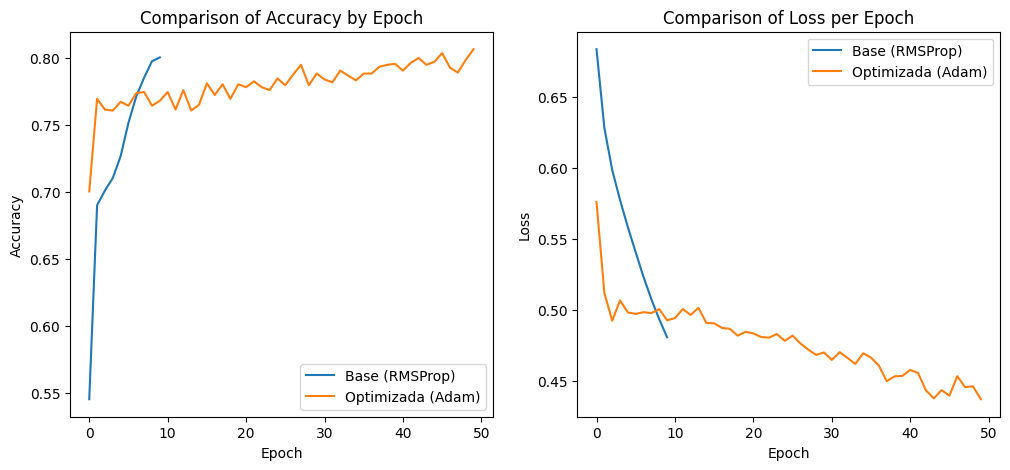

In [27]:
#BASE MODEL→ WITHOUT PCA (35 columnas)
metrics_base = get_metrics(model_base, X_test_processed, y_test)

# OPTIMIZED MODEL → WITH PCA (17 columnas)
metrics_opt = get_metrics(model_final, X_test_pca, y_test)

comparison_data = {
    'Model': ['Base RN', 'Optimized RN'],
    'Hyperparameters': [
        'L1(4), RMSProp, Batch:16, Ep:10',
        'L1(60), Adam, Batch:64'
    ],
    'Accuracy': [metrics_base['Accuracy'], metrics_opt['Accuracy']],
    'Precision': [metrics_base['Precision'], metrics_opt['Precision']],
    'Recall': [metrics_base['Recall'], metrics_opt['Recall']],
    'F1-Score': [metrics_base['F1'], metrics_opt['F1']]
}

df_comparison = pd.DataFrame(comparison_data)
display(df_comparison)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_base.history['accuracy'], label='Base (RMSProp)')
plt.plot(history_final.history['accuracy'], label='Optimizada (Adam)')
plt.title('Comparison of Accuracy by Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_base.history['loss'], label='Base (RMSProp)')
plt.plot(history_final.history['loss'], label='Optimizada (Adam)')
plt.title('Comparison of Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

The results show that the optimized model outperforms the baseline model in both accuracy and F1-score. Furthermore, the increase in recall indicates a better ability to correctly identify patients with Alzheimer's disease, which is particularly relevant in medical applications. The training curves show more stable and progressive learning in the optimized model, confirming the effectiveness of hyperparameter tuning and the use of PCA.

<div id="results" style="color:#37475a; border-bottom: 7px solid orange; width: 100%; margin-bottom: 15px; padding-bottom: 2px"><h2>Results</h2> </div>

The performance of the neural network models was evaluated using Accuracy, Precision, Recall, and F1-score.
Table X summarizes the results obtained for the baseline neural network and the optimized neural network.

The baseline neural network, configured with a single hidden layer of 4 neurons, RMSProp optimizer, a batch size of 16, and 10 training epochs, achieved an accuracy of 0.80. While the model obtained a relatively high precision (0.84), its recall was considerably lower (0.53), indicating limited capability in identifying positive Alzheimer’s cases. This imbalance resulted in a moderate F1-score of 0.65.

In contrast, the optimized neural network, obtained through hyperparameter tuning and trained with PCA-reduced data, demonstrated improved overall performance. The optimized model achieved a higher accuracy of 0.83 and a substantially better recall of 0.67, reflecting a stronger ability to correctly identify Alzheimer’s cases. Although precision slightly decreased to 0.82, the overall balance between precision and recall improved, leading to a higher F1-score of 0.74.

These results indicate that hyperparameter optimization and dimensionality reduction significantly enhance the model’s classification performance, particularly in terms of recall and F1-score.



<div id="conclusion" style="color:#37475a; border-bottom: 7px solid orange; width: 100%; margin-bottom: 15px; padding-bottom: 2px"><h2>Conclusion</h2> </div>
The optimized neural network achieved a better balance between precision and recall, resulting in a higher F1-score and improved overall accuracy. This improvement is especially important in medical classification tasks, where correctly identifying affected patients is critical.

Overall, the results confirm that model optimization and dimensionality reduction are essential steps for improving predictive performance, making the optimized neural network a more reliable approach for Alzheimer’s disease prediction compared to the baseline model.

<div id="references" style="color:#37475a; border-bottom: 7px solid orange; width: 100%; margin-bottom: 15px; padding-bottom: 2px"><h2>References</h2> </div>

GeeksforGeeks. (2025, March 28). Adam optimizer. https://www.geeksforgeeks.org/deep-learning/adam-optimizer/

Analytics Vidhya. (2022, January). Introduction to neural networks. https://www.analyticsvidhya.com/blog/2022/01/introduction-to-neural-networks/

Databricks. (2025, June 10). MLflow model management. https://docs.databricks.com/aws/en/mlflow/models